# Generating Investigative Leads from DNA Data
<b> <i>Mapping Forensic Y-Short Tandem Repeats to Haplogroups (Ethnicities)</i></b>

**COSCI221 - Machine Learning 1**

**Kenneth T. Co, PhD**
  
*Final Project*

**<u>MSDS 2026 Learning Team 8, Term 2</u>**

- Francis Erdey M. Capati
   
- Kevin Ansel S. Dy

- Jan Paolo V. Moreno

- Mia Cielo G. Oliveros

## Abstract


Genetic markers, particularly Y-chromosome short tandem repeats (Y-STRs), play a critical role in forensic investigations. Because Y-STRs are inherited strictly along the paternal line, it can help differentiate male lineages. However, its forensic value depends heavily on the availability of reference profiles in population databases. When no corresponding entry exists, a generated Y-STR profile cannot be used for direct identification.

This study addresses this limitation by proposing an alternative approach: **mapping Y-STRs to haplogroups**. Haplogroups represent major branches of the paternal lineage and can provide informative ancestral context even in the absence of an exact database match.

Key concepts include:
1. Y-chromosome: The chromosome that is passed down from father to son, and is present only in males
2. Y-STRs: Repetitive DNA patterns on the Y-chromosome
3. Haplogroups: Defines the largest branches on the paternal family tree, which can be treated as a 'genetic ethnicity' (e.g., East Asian, Western European, etc.)

By using machine learning to map Y-STR profiles to haplogroups, this approach enables investigators to extract meaningful lineage information and helps in ruling out or including a person in a suspect list.

## Data Source

The dataset utilized in the study originates from the supplementary material of YHP: Y-chromosome Haplogroup Predictor (Song et al., 2024), which trained machine-learning models to predict Y-SNP haplogroups from Y-STR haplotypes [1].

Below are the following information about the dataset:
1. 4,064 total rows

2. 27 features (e.g. DYS576, DYS389 I)
    - Values: Allele Counts (int)

3. 13 targets
    - Major Haplogroups (e.g. O, C, G)

Other columns included are the following:
- Total Frequency
- Haplotype
- Sample ID
- Population
- Frequency

## Methodology

Step 1. Conduct Exploratory Data Analysis

Step 2. Identify Machine Learning Models to use

Step 3. Identify Key Evaluation Metrics

Step 4. Build and Test Machine Learning Models

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import ElasticNet
from collections import Counter
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

c:\Users\Admin\OneDrive\Documents\AIM MSDS 2026\GitVSCode\Final Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Preprocessing

Before conducting any exploratory analysis or building predictive models, the dataset underwent preprocessing steps to ensure that the genetic markers and haplogroup information were in a clean, usable format. The raw data were first loaded from the supplemental spreadsheet and forward-filled to address missing entries inherited from the table’s hierarchical structure. The haplotype field, which was originally stored as a comma-separated string, was then parsed into separate columns representing individual Y-STR markers, each of which was assigned a standardized marker name for clarity and consistency. After extracting these markers, the original haplotype string was removed, and a new variable identifying the major haplogroup was generated based on the first letter of each haplogroup label. These preprocessing steps established a structured, fully numeric dataset suitable for downstream exploratory data analysis and machine learning workflows.

In [2]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)

# Step 2. Fill NaN values
df = df.ffill()

# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
YSTRs = {0: "DYS576", 1: "DYS389 I", 2: "DYS635", 3: "DYS389 II", 4: "DYS627", 5: "DYS460", 6: "DYS458",
                 7: "DYS19", 8: "Y-GATA-H4", 9: "DYS448", 10: "DYS391", 11: "DYS456", 12: "DYS390", 13: "DYS438", 
                 14: "DYS392", 15: "DYS518", 16: "DYS570", 17: "DYS437", 18: "DYS385a", 19: "DYS385b", 20: "DYS449", 
                 21: "DYS393", 22: "DYS439", 23: "DYS481", 24: "DYS576a", 25: "DYS576b", 26: "DYS533"
}

df = df.rename(columns=YSTRs)
df = df.drop(columns=['haplotype'])

# Step 4. Identify major haplogroups
hap_col = df.columns[0]
df["major_haplogroup"] = df[hap_col].str.extract(r"^([A-Z])")
df


,haplogroup,number_of_haplotypes,total_frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533,major_haplogroup
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0,C
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0,C
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0,O
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0,O
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0,O
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0,O


### 2. Exploratory Data Analysis

Exploratory Data Analysis (EDA) was conducted to understand the structure, quality, and underlying patterns within the dataset. The dataset comprises multiple categorical and numerical variables, including haplogroup labels, population information, and allele repeat counts for several Y-STR genetic markers.

The goal of this analysis is to examine the distribution and variability of these markers across haplogroups and populations, assess data completeness, and identify potential relationships among genetic features. By systematically exploring marker distributions, inter-marker correlations, and population-level differences, this EDA aims to determine whether the dataset exhibits structured and non-random patterns which serves as empirical evidence for the feasibility of predictive modeling using machine learning.

#### 2.1. Data Overview

Shape:(4064, 34)

Count of missing values in dataset: 0



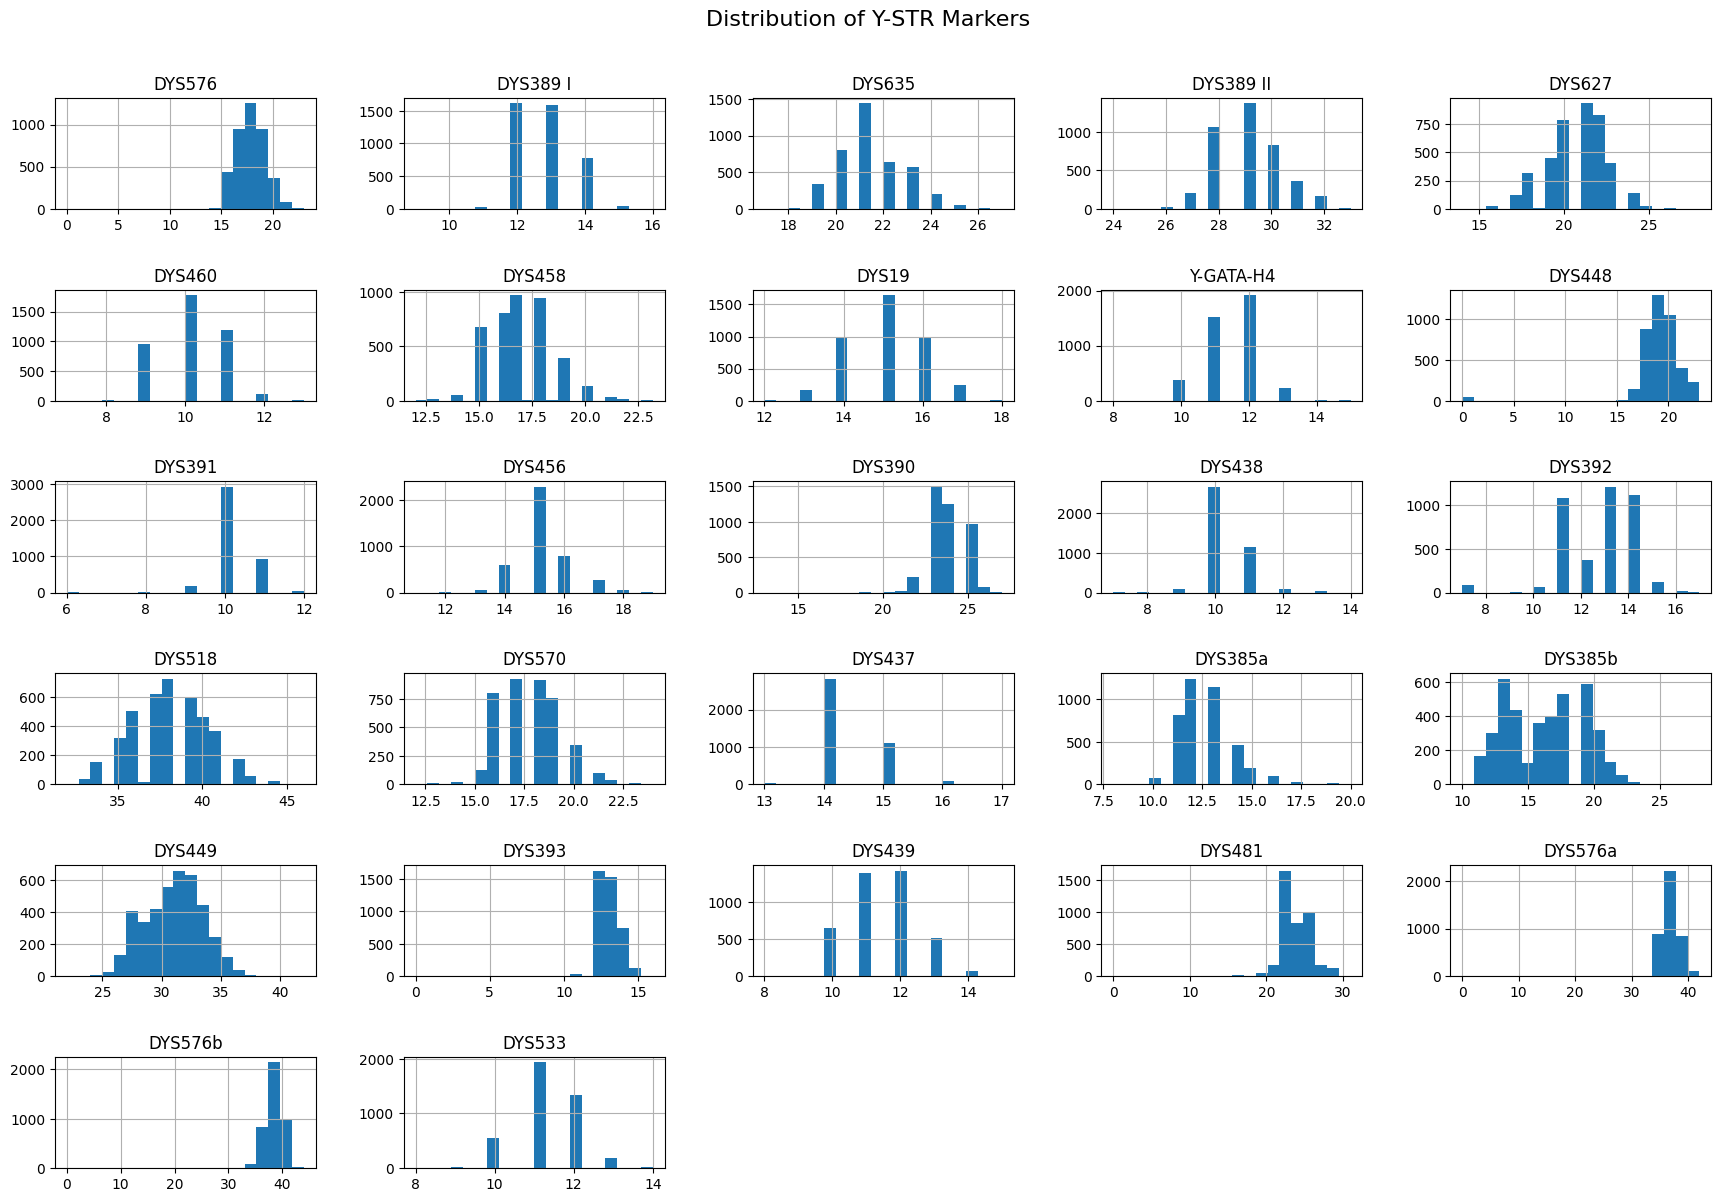

In [3]:
print(f"Shape:{df.shape}")
print(f"\nCount of missing values in dataset: {df.isna().sum().sum()}\n")

marker_cols = ['DYS576', 'DYS389 I', 'DYS635', 'DYS389 II', 'DYS627', 'DYS460', 'DYS458',
                 'DYS19', 'Y-GATA-H4', 'DYS448', 'DYS391', 'DYS456', 'DYS390', 'DYS438', 
                 'DYS392', 'DYS518', 'DYS570', 'DYS437', 'DYS385a', 'DYS385b', 'DYS449', 
                 'DYS393', 'DYS439', 'DYS481', 'DYS576a', 'DYS576b', 'DYS533']
# id_cols = ['haplogroup', 'population', 'sampleID']
# num_cols = ['number of haplotypes', 'total frequency', 'frequency']

df[marker_cols] = df[marker_cols].apply(pd.to_numeric, errors='coerce')
df[marker_cols].hist(figsize=(18, 12), bins=20)
plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=2.5)
plt.suptitle("Distribution of Y-STR Markers", fontsize=16, y=1.02)
plt.show()

<b> Analysis </b>

The dataset comprises a total of 4,064 observations. Following data preprocessing, the final structure consists of 33 variables. A check for missing values showed that all columns are complete, making the dataset ready for analysis.

The Y-STR marker distributions reveal a mix of allele patterns across different loci. Some markers, like DYS449, DYS458, and DYS385a/b, show wide and often multimodal distributions, suggesting higher genetic diversity and stronger potential to distinguish between haplogroups or populations. In contrast, markers such as DYS391, DYS393, and DYS437 are more narrowly distributed, indicating conserved loci that contribute stability but less variation. Overall, the distinct and structured differences observed across markers point to meaningful genetic variation in the dataset, supporting its suitability for further modeling and classification analysis.

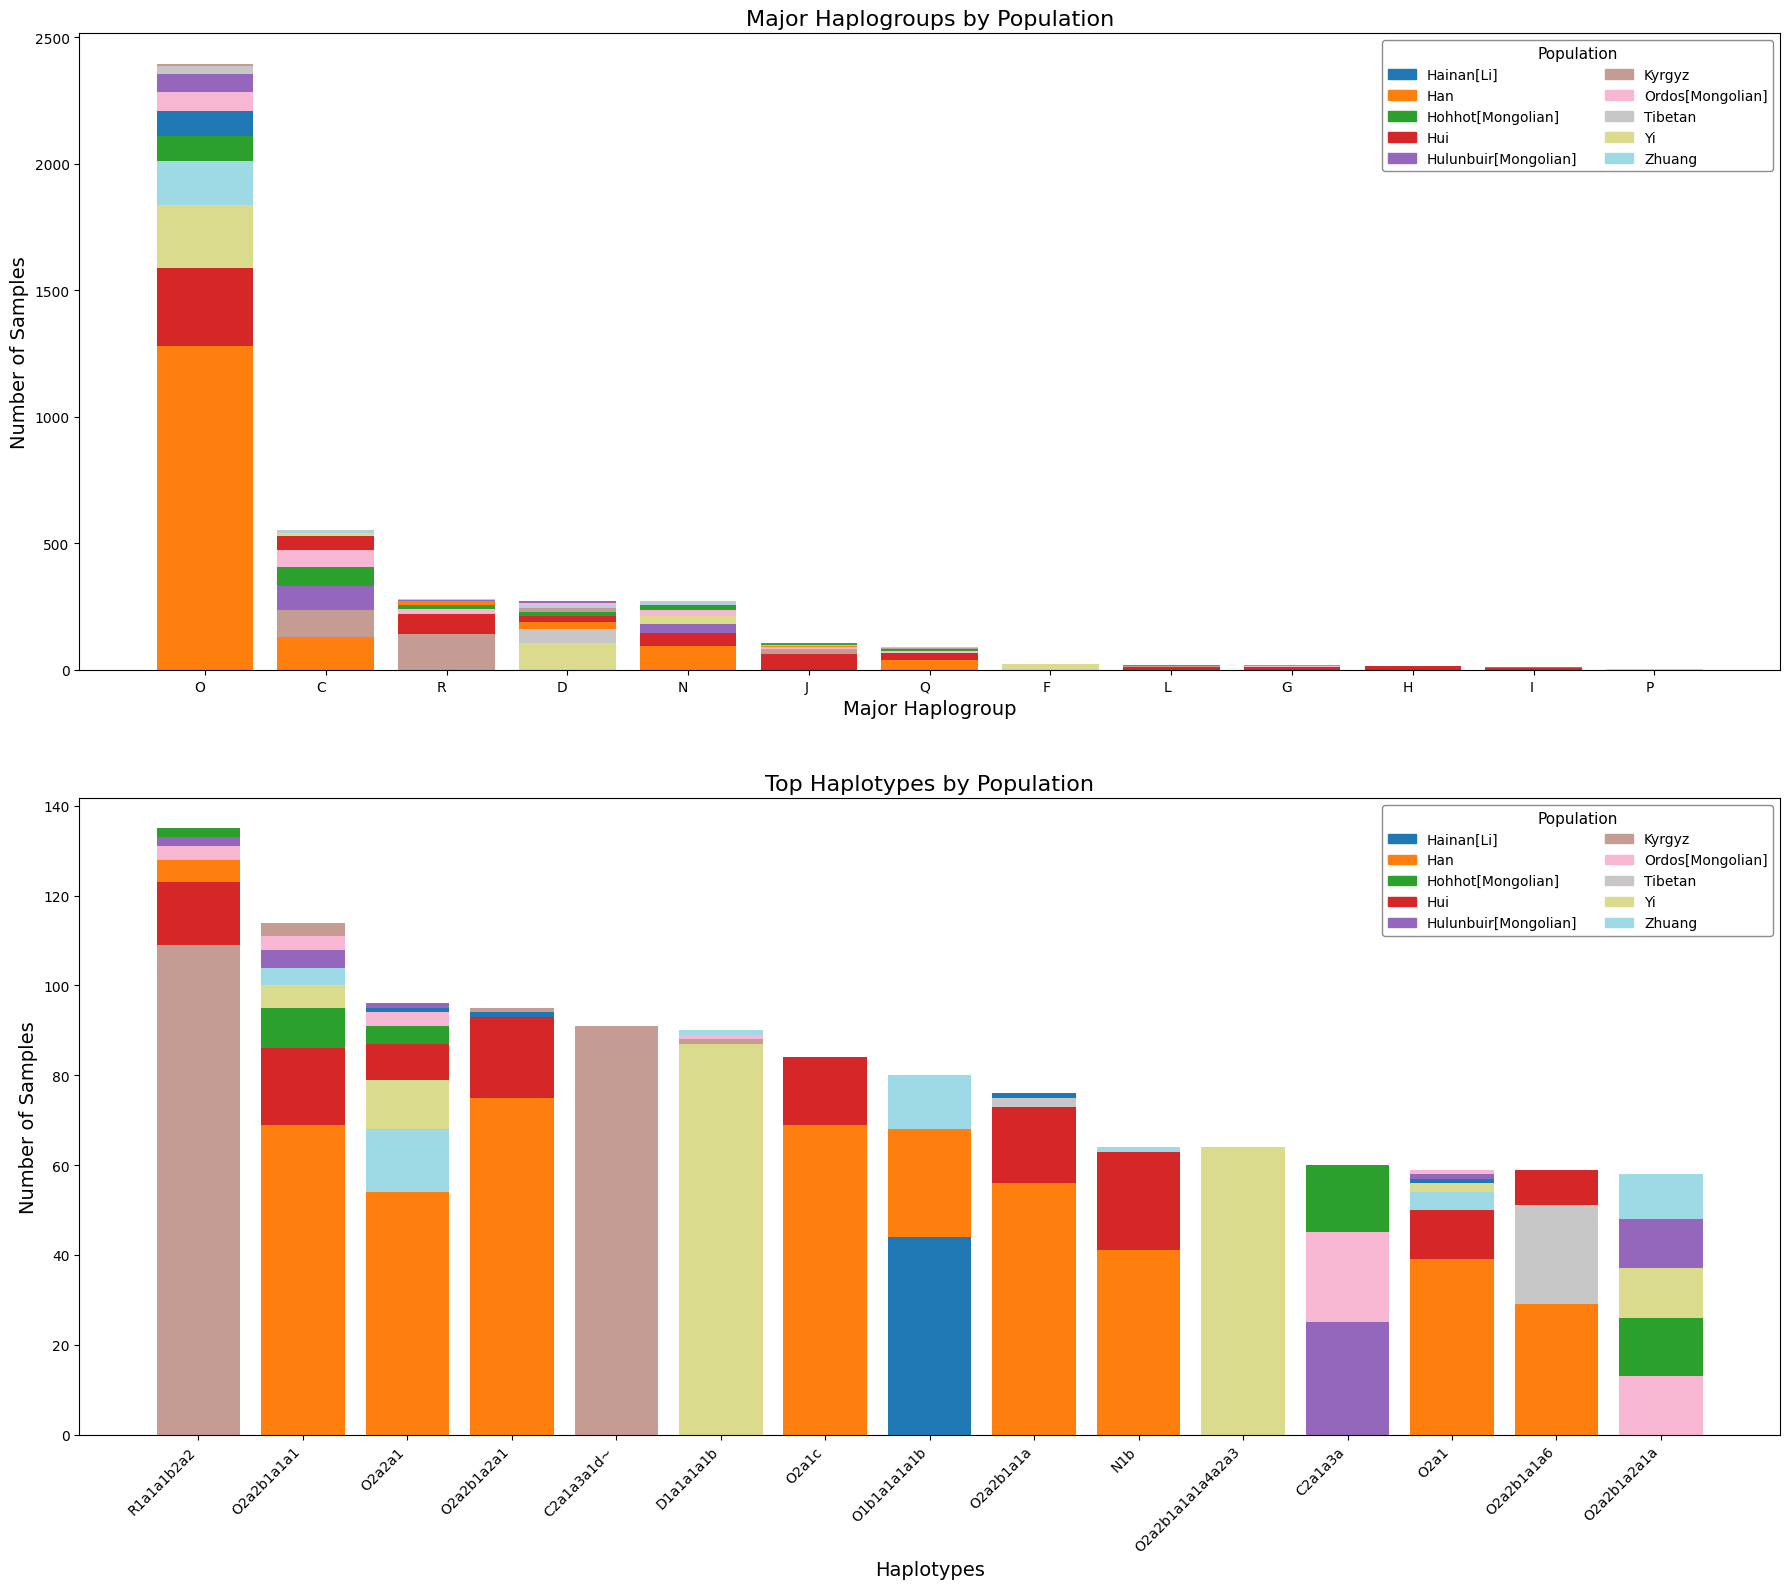

In [4]:
# Create combined figure with two subplots (top and bottom)
fig, axes = plt.subplots(2, 1, figsize=(18, 16))  # 2 rows, 1 column

# ---------- TOP PLOT: Major Haplogroups ----------
grouped_major = df.groupby(['major_haplogroup', 'population']).size().unstack(fill_value=0)
top_major = grouped_major.sum(axis=1).nlargest(15).index
grouped_major_top = grouped_major.loc[top_major]

# Assign colors
populations = grouped_major_top.columns
colors = plt.cm.tab20(np.linspace(0, 1, len(populations)))
color_map = dict(zip(populations, colors))

# Plot
x = np.arange(len(grouped_major_top))
bottom = np.zeros(len(grouped_major_top))

for i in range(len(grouped_major_top)):
    row = grouped_major_top.iloc[i].sort_values(ascending=False)
    for pop, value in row.items():
        if value > 0:
            axes[0].bar(x[i], value, bottom=bottom[i], color=color_map[pop], width=0.8)
            bottom[i] += value

# Format top plot
axes[0].set_xticks(x)
axes[0].set_xticklabels(grouped_major_top.index, rotation=360, ha='right')
axes[0].set_title("Major Haplogroups by Population", fontsize=16)
axes[0].set_xlabel("Major Haplogroup", fontsize=14)
axes[0].set_ylabel("Number of Samples", fontsize=14)

# Legend (inside top plot)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[pop]) for pop in populations]
legend = axes[0].legend(
    handles, populations,
    title="Population",
    loc='upper right',
    frameon=True,
    fontsize=10,
    title_fontsize=11,
    ncol=2
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('gray')

# ---------- BOTTOM PLOT: Haplogroups ----------
grouped_hap = df.groupby(['haplogroup', 'population']).size().unstack(fill_value=0)
top_haps = grouped_hap.sum(axis=1).nlargest(15).index
grouped_hap_top = grouped_hap.loc[top_haps]

# Plot
x = np.arange(len(grouped_hap_top))
bottom = np.zeros(len(grouped_hap_top))

for i in range(len(grouped_hap_top)):
    row = grouped_hap_top.iloc[i].sort_values(ascending=False)
    for pop, value in row.items():
        if value > 0:
            axes[1].bar(x[i], value, bottom=bottom[i], color=color_map[pop], width=0.8)
            bottom[i] += value

# Format bottom plot
axes[1].set_xticks(x)
axes[1].set_xticklabels(grouped_hap_top.index, rotation=45, ha='right')
axes[1].set_title("Top Haplotypes by Population", fontsize=16)
axes[1].set_xlabel("Haplotypes", fontsize=14)
axes[1].set_ylabel("Number of Samples", fontsize=14)

# Legend (inside bottom plot)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[pop]) for pop in populations]
legend = axes[1].legend(
    handles, populations,
    title="Population",
    loc='upper right',
    frameon=True,
    fontsize=10,
    title_fontsize=11,
    ncol=2
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('gray')

# ---------- Final Layout ----------
plt.tight_layout(h_pad=4.0)  # Add space between plots
plt.show()

<b> Analysis </b>

The stacked bar chart highlights a clear class imbalance across haplogroups, with a few major lineages such as R1a1b2a2 and O2a2b1a1a1 contributing the majority of samples, while others appear far less frequently. Within these haplogroups, certain populations, particularly the Han, dominate the sample composition, resulting in uneven representation across both genetic and population groups. This type of imbalance is expected in Y-SNP and Y-STR datasets, as haplogroup frequencies reflect deep historical and demographic patterns, including population expansions, founder effects, and region-specific sampling priorities. Larger datasets and public repositories also tend to oversample major lineages associated with well-studied populations, further reinforcing this skew.

Despite this imbalance, developing a machine learning model remains highly beneficial. Properly designed models can help identify subtle genetic patterns within underrepresented haplogroups, highlight population-specific variations, and support predictive classification when new Y-chromosomal profiles are encountered. Techniques such as stratified sampling, class weighting, or oversampling can mitigate bias, allowing the model to generalize beyond the dominant haplogroups. In this way, machine learning serves as a powerful analytical tool to handle the inherent imbalance while uncovering structure and diversity within complex Y-chromosomal data.

<b> Discussion: Class Imbalance & National Population Distribution </b>

The predominance of certain haplogroups and populations in the dataset is not merely a sampling artefact. It reflects the actual demographic and genetic composition of China. According to the Y-Chromosome Haplotype Reference Database (YHRD), China’s national database contains over 132,000 haplotypes, the largest national collection within YHRD [2]. Within this database, the Han Chinese meta-population accounts for the overwhelming majority of entries, with 98,957 haplotypes compared to only a few thousand from minority groups. Similarly, demographic data show that the Han ethnic group constitutes approximately 91% of China’s total population. This clear dominance at both the genetic and population levels helps explain the imbalance observed in the dataset.

Because Y-SNP and Y-STR data trace male lineage and paternal inheritance, haplogroups that are historically prevalent among the Han, such as O2 and its subclades, are naturally more frequent. In contrast, haplogroups associated with smaller ethnic minorities, such as Tibetan, Uyghur, or Mongolic lineages, are less represented. As a result, the dataset exhibits both between-class imbalance (some haplogroups having far more samples than others) and within-class imbalance (haplogroups dominated by one population, with limited diversity).

While such imbalance is expected due to historical demographic expansions, founder effects, and the concentration of YHRD submissions from major populations, it has implications for downstream modeling. A machine learning model trained directly on this data may overfit to the majority haplogroups and underperform for minority lineages. However, when properly handled—using stratified sampling, class weighting, or oversampling—machine learning can still uncover informative genetic patterns, identify rare variants, and support lineage prediction for underrepresented groups. Thus, even though the imbalance reflects China’s real population structure, modeling remains valuable for generalizing insights across both common and rare paternal lineages.

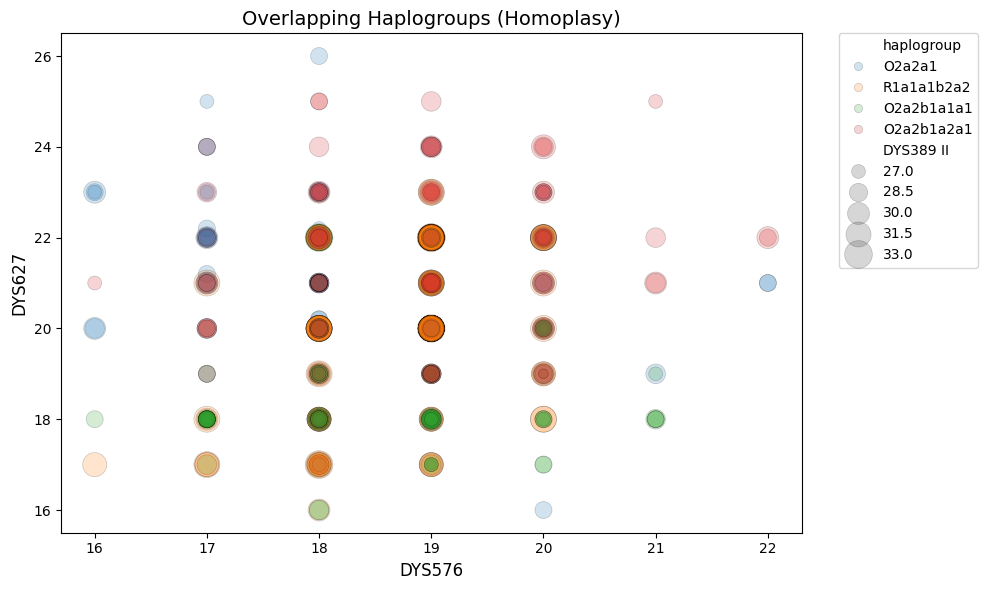

In [5]:
# Filter only the target haplogroups
df_sample = df[
    (df['haplogroup'] == 'R1a1a1b2a2') |
    (df['haplogroup'] == 'O2a2b1a1a1') |
    (df['haplogroup'] == 'O2a2a1') |
    (df['haplogroup'] == 'O2a2b1a2a1')
]

# Create bubble chart
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=df_sample,
    x='DYS576',
    y='DYS627',
    hue='haplogroup',
    size='DYS389 II',
    sizes=(50, 400),
    alpha=0.2,
    edgecolor='black',
    linewidth=0.5
)

# Format the legend and labels
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title('Overlapping Haplogroups (Homoplasy)', fontsize=14)
plt.xlabel('DYS576', fontsize=12)
plt.ylabel('DYS627', fontsize=12)

plt.tight_layout()
plt.show()

<b> Discussion </b>

Samples from different haplogroups share the same features. Therefore the allele count of any single loci cannot be used to distinguish one haplogroup from another.

This phenomenon is called <b> Homoplasy </b> wherein two people have the same Y-STR score for a loci, but did not originate from the same recent ancestor.

### 3. Identify Key Evaluation Metrics

<i>Model Evaluation Metrics for Y-STR Haplogroup Classification</i>

**Overview**

To evaluate the performance of classifiers trained on Y-STR data, a suite of **multi-class performance metrics** designed to capture accuracy, balance, and generalization across unevenly distributed haplogroups is employed.

The dataset exhibits **hierarchical class structure** (Y-SNP Haplogroups to subclades/haplotypes) and **class imbalance** (some haplogroups and haplotypes have far fewer samples).

Therefore, standard accuracy alone is insufficient to adequately measure the performance of the model. Therefore, we also measured **macro-averaged F1**, and **delta macro averaged F1** (train and test) to provide a more robust evaluation.

---

**Accuracy**

**Definition:**

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

In a multi-class context:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of samples}}
$$

Accuracy provides an overall measure of correctness, but it can be **misleading under class imbalance** — high accuracy can occur even if minority haplogroups are misclassified entirely.

**Interpretation:**
- High accuracy means most samples are correctly classified across all classes.
- However, accuracy does not account for per-class representation.

---

**Precision, Recall, and F1-Score**

These metrics are computed **per class** and then averaged. They are fundamental to understanding trade-offs between **false positives** and **false negatives**.

Precision

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}
$$

Measures how many predicted members of class $k$ are actually correct.

- High precision → few false positives  
- In Y-STR terms: when the model predicts haplogroup *R1a*, it’s often correct.

Recall (Sensitivity)

$$
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}
$$

Measures how many true members of class $k$ were successfully identified.

- High recall → few false negatives  
- In Y-STR terms: most true *R1a* individuals are captured by the model.

F1-Score

The **harmonic mean** of precision and recall:

$$
F1_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
$$

The harmonic mean penalizes extreme imbalance (e.g., perfect precision but poor recall).

---

**Macro-Averaged F1**

To obtain a single number summarizing performance across all haplogroups:

$$
F1_{\text{macro}} = \frac{1}{K} \sum_{k=1}^K F1_k
$$

- **Each class contributes equally**, regardless of frequency.  
- This is crucial for **imbalanced datasets**, ensuring that rare haplogroups (e.g., *G*, *L*) are weighted equally to dominant ones (e.g., *O*, *R*).

**Interpretation:**
- A high macro-F1 implies balanced performance across both common and rare haplogroups.
- A large gap between training and test macro-F1 indicates **overfitting** (model memorizing rare haplogroups).


---

**Overfitting Analysis (Train vs Test)**

To assess overfitting, the macro-F1 scores between train and test set will be compared:

$$
\Delta F1 = F1_{\text{train}} - F1_{\text{test}}
$$

- Small $\Delta F1$ → model generalizes well  
- Large $\Delta F1$ → potential overfitting (especially in rare classes)


---

**Summary Table**

| Metric | Purpose | Robust to Imbalance | Interpretation |
|:--------|:---------|:--------------------|:----------------|
| Accuracy | Overall correctness | No | Sensitive to dominant classes |
| Precision | Confidence in positive predictions | Yes (per class) | Penalizes false positives |
| Recall | Completeness of detection | Yes (per class) | Penalizes false negatives |
| F1-score | Balance of precision & recall | Yes | Unified detection performance |
| Macro-F1 | Equal weighting of all classes | Yes | Key for imbalanced haplogroups |

---

**8. Summary**

- **Accuracy** alone is insufficient in the presence of rare haplogroups.
- **Train–test Macro F1 score gaps** quantifies whether the model is overfitting or generalizing sufficiently.

These evaluation metrics provide comprehensive and balanced view of the model's performance on Y-SNP classification with Y-STR's.


### 4. Build and Test Machine Learning Models

#### 4.1. AutoML and Model Selection

The following models will be utilized for this study:
1. KNN
2. LDA
3. Gaussian Naive Bayes
4. Decision Tree
5. Random Forest

KNN is suited for handling discrete data and classification problems. Moreover, the model works well for data with non-linear linearships. Scaling will be applied to help with faster convergence, equal feature contribution, and improved performance [3][4].

LDA is suited for multi-class data classifications since it projects data into one dimension for easier classification (i.e. dimensionality reduction). Given the nature of the dataset, this will be included as part of the models that will be trained and tested.

Gaussian Naive Bayes (GNB) will also be utilized since it is effective for classification problems. However, it is worth noting that GNB assumes the dataset follows a normal distribution.

Since Decision Tree and Random Forest are suited for rule based problems and handling discrete data, both will be included in models that will be created.

Random Forest will be utilized instead of the general Gradient Boosting Machine due to the nature of the dataset. Given the size of the dataset, it may be difficult to use Gradient Boosting Machine due to its sequential nature of training making it less scalable, and handling the data less efficiently [5].

Although Logistic Regression also handles discrete data and classification problems, it is more suited for cases where the target variable is binary and there is a linear relationship between the dependent variable and the independent variables [6]. Given that the dataset has overlapping classes as seen in the EDA section, it will be difficult to establish the linearity between the target and the features. As such, Logistic Regression (L1, L2) will not be used.

SVM will also not be used because the dataset has overlapping classes [7]. As an example, plotting two of the features (i.e. DYS627 and DYS576) show overlaps between the four haplogroups (i.e. R1a1a1b2a2, O2a2b1a1a1, O2a2a1, O2a2b1a2a1) as seen in the EDA section. In addition, SVM is more appropriate for cases where the data is continuous which is why SVM will be excluded.

In [6]:
X_full = df.iloc[:, 6:33]
y_full = df.iloc[:, 33]

# 25% true test set
X_train_h, X_holdout, y_train_h, y_holdout = train_test_split(
    X_full, y_full, test_size=0.25, stratify=y_full, random_state=42
)

print("Train-H size:", X_train_h.shape)
print("Holdout size:", X_holdout.shape)

Number_trials = 20
KFOLDS = 5

all_splits = []

for seed in range(Number_trials):
    skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=seed)
    
    fold_list = []
    for train_idx, test_idx in skf.split(X_train_h, y_train_h):
        fold_list.append((train_idx, test_idx))

    all_splits.append(fold_list)

Train-H size: (3048, 27)
Holdout size: (1016, 27)


In [7]:
def train_knn(X, y):
    start_time = time.time()
    all_scores = np.zeros(69)

    for trial in range(Number_trials):
        scaler = MinMaxScaler()

        for train_idx, test_idx in all_splits[trial]:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            for k in range(1, 70):
                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train, y_train)
                all_scores[k-1] += knn.score(X_test, y_test)

    all_scores /= (Number_trials * KFOLDS)
    best_k = np.argmax(all_scores) + 1

    return ["kNN", np.max(all_scores), f"k={best_k}", "NA", time.time() - start_time]


In [8]:
def train_lda(X, y):
    start_time = time.time()
    solvers = ["svd", "lsqr", "eigen"]
    scores = np.zeros(len(solvers))

    for trial in range(Number_trials):
        for train_idx, test_idx in all_splits[trial]:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            for i, solver in enumerate(solvers):
                lda = LinearDiscriminantAnalysis(solver=solver)
                lda.fit(X_train, y_train)
                scores[i] += lda.score(X_test, y_test)

    scores /= (Number_trials * KFOLDS)
    best_solver = solvers[np.argmax(scores)]

    return ["LDA", np.max(scores), f"solver={best_solver}", "NA", time.time() - start_time]


In [9]:
def train_gaussian_nb(X, y):
    start_time = time.time()
    varsmooth = [1e-9, 1e-8, 1e-7, 1e-6]
    scores = np.zeros(len(varsmooth))

    for trial in range(Number_trials):
        for train_idx, test_idx in all_splits[trial]:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            for i, v in enumerate(varsmooth):
                model = GaussianNB(var_smoothing=v)
                model.fit(X_train, y_train)
                scores[i] += model.score(X_test, y_test)

    scores /= (Number_trials * KFOLDS)
    best_v = varsmooth[np.argmax(scores)]

    return ["Gaussian NB", np.max(scores), f"var_smoothing={best_v}", "NA", time.time() - start_time]


In [10]:
def train_decision_tree(X, y):
    start_time = time.time()
    depths = [2, 4, 6, 8, 10, None]
    crits = ["gini", "entropy"]
    min_splits = [2, 5, 10]

    combos = [(c, d, m) for c in crits for d in depths for m in min_splits]
    scores = np.zeros(len(combos))

    for trial in range(Number_trials):
        for train_idx, test_idx in all_splits[trial]:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            for i, (crit, d, m) in enumerate(combos):
                dt = DecisionTreeClassifier(
                    criterion=crit, max_depth=d,
                    min_samples_split=m, random_state=trial
                )
                dt.fit(X_train, y_train)
                scores[i] += dt.score(X_test, y_test)

    scores /= (Number_trials * KFOLDS)
    best_i = np.argmax(scores)
    best = combos[best_i]

    return [
        "Decision Tree",
        np.max(scores),
        f"criterion={best[0]}, max_depth={best[1]}, min_samples_split={best[2]}",
        "NA",
        time.time() - start_time
    ]


In [11]:
def train_random_forest_mc(X, y):
    start_time = time.time()
    depths = range(1, 21)
    nests = [10, 50, 100, 200]

    results = []

    for d in depths:
        for n in nests:

            accs = []

            for trial in range(Number_trials):
                for train_idx, test_idx in all_splits[trial]:
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                    rf = RandomForestClassifier(
                        n_estimators=n,
                        max_depth=d,
                        n_jobs=-1,
                        random_state=trial
                    )
                    rf.fit(X_train, y_train)
                    accs.append(rf.score(X_test, y_test))

            results.append((np.mean(accs), n, d))

    best = max(results, key=lambda x: x[0])

    return [
        "Random Forest",
        best[0],
        f"n_estimators={best[1]}, max_depth={best[2]}",
        "NA",
        time.time() - start_time
    ]


In [12]:
def train_elastic_net(X, y):
    start_time = time.time()

    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    alphas = [0.1, 0.5, 1.0]
    l1s = [0.1, 0.5, 0.9]
    results = []

    for a in alphas:
        for l in l1s:

            accs = []

            for trial in range(Number_trials):
                for train_idx, test_idx in all_splits[trial]:
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y_enc[train_idx], y_enc[test_idx]

                    model = ElasticNet(alpha=a, l1_ratio=l)
                    model.fit(X_train, y_train)

                    pred = np.clip(np.round(model.predict(X_test)), 0, len(le.classes_)-1)
                    accs.append(accuracy_score(y_test, pred))

            results.append((np.mean(accs), a, l))

    best = max(results, key=lambda x: x[0])

    return ["Elastic Net", best[0], f"alpha={best[1]}, l1_ratio={best[2]}", "NA", time.time() - start_time]


In [13]:
def train_xgboost(X, y):
    start_time = time.time()

    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    depths = [3, 5, 7]
    nests = [100, 200]
    lrs = [0.01, 0.1, 0.2]

    results = []

    for lr in lrs:
        for d in depths:
            for n in nests:

                accs = []

                for trial in range(Number_trials):
                    for train_idx, test_idx in all_splits[trial]:
                        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                        y_train, y_test = y_enc[train_idx], y_enc[test_idx]

                        model = XGBClassifier(
                            learning_rate=lr,
                            max_depth=d,
                            n_estimators=n,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            eval_metric="mlogloss",
                            n_jobs=-1,
                            random_state=trial
                        )
                        model.fit(X_train, y_train)
                        accs.append(model.score(X_test, y_test))

                results.append((np.mean(accs), lr, d, n))

    best = max(results, key=lambda x: x[0])

    return ["XGBoost",
            best[0],
            f"learning_rate={best[1]}, max_depth={best[2]}, n_estimators={best[3]}",
            "NA",
            time.time() - start_time]


In [14]:
def train_svm(X, y):
    start_time = time.time()

    Cs = [0.1, 1, 10]
    kernels = ["linear", "rbf"]
    gammas = ["scale", "auto"]

    results = []

    for C in Cs:
        for kernel in kernels:
            for gamma in gammas:

                accs = []

                for trial in range(Number_trials):
                    for train_idx, test_idx in all_splits[trial]:

                        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                        model = SVC(C=C, kernel=kernel, gamma=gamma)
                        model.fit(X_train, y_train)
                        accs.append(model.score(X_test, y_test))

                results.append((np.mean(accs), C, kernel, gamma))

    best = max(results, key=lambda x: x[0])
    best_acc, best_C, best_kernel, best_gamma = best

    return [
        "SVM",
        best_acc,
        f"C={best_C}, kernel={best_kernel}, gamma={best_gamma}",
        "NA",
        time.time() - start_time
    ]

In [15]:
knn_df = train_knn(X_train_h, y_train_h)
lda_df = train_lda(X_train_h, y_train_h)
gnb_df = train_gaussian_nb(X_train_h, y_train_h)
dt_df = train_decision_tree(X_train_h, y_train_h)
random_forest_df = train_random_forest_mc(X_train_h, y_train_h)
elastic_net_df = train_elastic_net(X_train_h, y_train_h)
xgb_df = train_xgboost(X_train_h, y_train_h)
svm_df = train_svm(X_train_h, y_train_h)

In [16]:
automl_df = pd.DataFrame(
    columns=['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
)

automl_df.loc[0] = knn_df
automl_df.loc[1] = lda_df
automl_df.loc[2] = gnb_df
automl_df.loc[3] = dt_df
automl_df.loc[4] = random_forest_df
automl_df.loc[5] = elastic_net_df
automl_df.loc[6] = xgb_df
automl_df.loc[7] = svm_df

automl_df = automl_df.drop(columns='Top Predictor Variable')
display(automl_df)

# Identify best model
best_idx = automl_df["Test Accuracy"].astype(float).idxmax()
best_model_name = automl_df.loc[best_idx, "Machine Learning Method"]
print(f"\nBest Performing Model: {best_model_name}")

,Machine Learning Method,Test Accuracy,Best Parameter,Run Time
0,kNN,0.961631,k=3,61.068099
1,LDA,0.943801,solver=lsqr,2.298917
2,Gaussian NB,0.935188,var_smoothing=1e-06,1.925661
3,Decision Tree,0.934219,"criterion=gini, max_depth=8, min_samples_split=2",32.055483
4,Random Forest,0.967995,"n_estimators=100, max_depth=18",1063.729958
5,Elastic Net,0.202903,"alpha=0.5, l1_ratio=0.9",1.856431
6,XGBoost,0.969800,"learning_rate=0.2, max_depth=7, n_estimators=200",741.275288
7,SVM,0.962302,"C=0.1, kernel=linear, gamma=scale",183.728260



Best Performing Model: XGBoost


#### 4.2 Hyperparameter Tuning

Given that the Random Forest model outperformed all other tested models, it was selected for hyperparameter tuning. The approach for hyperparameter tuning is by using GridSearchCV which trains and evaluates each combination using cross-validation (e.g., 5-fold Stratified K-Fold), selects the best average score, and then retrains the model on all training data with those optimal parameters. This is also combined with StratifiedShuffleSplit each haplogroup is proportionally represented in both sets, preventing bias from class imbalance.

Furthermore, the parameter <i>class_weight='balanced'</i> was applied to the models since it automatically adjusts weights inversely proportional to the class frequencies [8]. This means that the lower the count of the class, the higher the weight (i.e. penalty) assigned. With this approach, the model tries to balance its attention between the classes with the highest frequency and classes with the highest penalty to address the class imbalance.

In [ ]:
def evaluate_final_model(model_cls, best_params, X_train_h, y_train_h, 
                         X_holdout, y_holdout, feature_type="tree"):
    """
    model_cls: classifier class (e.g. XGBClassifier)
    best_params: dict of hyperparameters from CV stage
    feature_type: "tree" or "coef"
    """

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train_h)
    y_holdout_enc = le.transform(y_holdout)
    class_names = le.classes_

    # Train final model
    model = model_cls(**best_params)
    model.fit(X_train_h, y_train_enc)

    # Predict holdout
    y_pred = model.predict(X_holdout)

    # ======================================================
    # REPORT METRICS
    # ======================================================
    print("\n===== HOLDOUT CLASSIFICATION REPORT =====")
    print(classification_report(y_holdout_enc, y_pred, target_names=class_names))

    # Per-class accuracy
    print("\n===== PER-CLASS ACCURACY =====")
    for i, cls in enumerate(class_names):
        mask = (y_holdout_enc == i)
        print(f"{cls}: {accuracy_score(mask, (y_pred == i)):.4f}")

    # Per-class precision
    print("\n===== PER-CLASS PRECISION =====")
    precs = precision_score(y_holdout_enc, y_pred, average=None)
    for c, p in zip(class_names, precs):
        print(f"{c}: {p:.4f}")

    # Per-class recall
    print("\n===== PER-CLASS RECALL =====")
    recs = recall_score(y_holdout_enc, y_pred, average=None)
    for c, r in zip(class_names, recs):
        print(f"{c}: {r:.4f}")

    # ======================================================
    # CONFUSION MATRIX
    # ======================================================
    print("\n===== CONFUSION MATRIX =====")
    cm = confusion_matrix(y_holdout_enc, y_pred)
    print(cm)

    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.title("Holdout Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ======================================================
    # FEATURE IMPORTANCE
    # ======================================================
    if feature_type == "tree":  
        booster = model.get_booster()
        importances = booster.get_score(importance_type="gain")

        imp_series = (
            pd.Series(importances)
            .reindex(X_train_h.columns, fill_value=0)
            .sort_values(ascending=False)
        )

    elif feature_type == "coef":
        imp_series = pd.Series(
            np.abs(model.coef_).mean(axis=0),
            index=X_train_h.columns
        ).sort_values(ascending=False)

    print("\n===== TOP FEATURE IMPORTANCES =====")
    display(imp_series.head(20))

    plt.figure(figsize=(8,6))
    imp_series.head(20).plot(kind="bar")
    plt.title("Top Features")
    plt.tight_layout()
    plt.show()

    # ======================================================
    # SHAP VALUES
    # ======================================================
    print("\n===== COMPUTING SHAP VALUES =====")
    explainer = shap.TreeExplainer(model) if feature_type == "tree" else shap.LinearExplainer(model, X_train_h)
    shap_values = explainer.shap_values(X_holdout)

    shap.summary_plot(shap_values, X_holdout, plot_type="bar")

    top_feat = imp_series.index[0]
    print("Top feature:", top_feat)
    shap.dependence_plot(top_feat, shap_values, X_holdout)

    return {
        "confusion_matrix": cm,
        # "feature_importances": imp_series
    }

In [18]:
def evaluate_best_model(
    automl_df,
    X_train_h, y_train_h,
    X_holdout, y_holdout,
    model_param_extractors
):
    """
    automl_df:
        DataFrame with columns:
        ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', ...]

    model_param_extractors:
        dict: { model_name : function(best_param_string) -> dict_of_params }
    """

    # ======================================================
    # 1. DETERMINE BEST MODEL
    # ======================================================
    best_idx = automl_df["Test Accuracy"].astype(float).idxmax()
    best_model_name = automl_df.loc[best_idx, "Machine Learning Method"]
    best_param_string = automl_df.loc[best_idx, "Best Parameter"]

    print("\n==============================")
    print(f"BEST MODEL SELECTED: {best_model_name}")
    print("FROM AUTO-ML CROSS-VALIDATION")
    print("==============================\n")

    if best_model_name not in model_param_extractors:
        raise ValueError(f"No parameter extractor for {best_model_name}")

    # Parse CV-found hyperparameters
    best_params = model_param_extractors[best_model_name](best_param_string)
    print("Best Hyperparameters:", best_params, "\n")

    # ======================================================
    # 2. MODEL CLASS SELECTION (maps model name → sklearn/XGB class)
    # ======================================================
    if best_model_name == "kNN":
        model_cls = KNeighborsClassifier
        feature_type = "none"    # no feature importances

    elif best_model_name == "LDA":
        model_cls = LinearDiscriminantAnalysis
        feature_type = "coef"    # coefficients

    elif best_model_name == "Gaussian NB":
        model_cls = GaussianNB
        feature_type = "none"

    elif best_model_name == "Decision Tree":
        model_cls = DecisionTreeClassifier
        feature_type = "tree"    # feature_importances_

    elif best_model_name == "Random Forest":
        model_cls = RandomForestClassifier
        feature_type = "tree"

    elif best_model_name == "Elastic Net":
        model_cls = ElasticNet
        feature_type = "coef"

    elif best_model_name == "SVM":
        model_cls = SVC
        feature_type = "coef"    # linear kernel only

    elif best_model_name == "XGBoost":
        model_cls = XGBClassifier
        feature_type = "tree"    # SHAP + gain

    else:
        raise ValueError(f"Model type not supported: {best_model_name}")

    # ======================================================
    # 3. TRAIN + EVALUATE FINAL MODEL USING UNIVERSAL FUNCTION
    # ======================================================
    results = evaluate_final_model(
        model_cls=model_cls,
        best_params=best_params,
        X_train_h=X_train_h,
        y_train_h=y_train_h,
        X_holdout=X_holdout,
        y_holdout=y_holdout,
        feature_type=feature_type
    )

    return results

In [19]:
import re

def parse_knn(param_string):
    k = int(param_string.split("=")[1])
    return {"n_neighbors": k}

def parse_lda(param_string):
    solver = param_string.split("=")[1]
    return {"solver": solver}

def parse_gnb(param_string):
    v = float(param_string.split("=")[1])
    return {"var_smoothing": v}

def parse_dt(param_string):
    d = dict(item.split("=") for item in param_string.split(", "))
    return {
        "criterion": d["criterion"],
        "max_depth": None if d["max_depth"]=="None" else int(d["max_depth"]),
        "min_samples_split": int(d["min_samples_split"])
    }

def parse_rf(param_string):
    d = dict(item.split("=") for item in param_string.split(", "))
    return {
        "n_estimators": int(d["n_estimators"]),
        "max_depth": int(d["max_depth"]),
        "n_jobs": -1,
        "random_state": 42
    }

def parse_elastic(param_string):
    d = dict(item.split("=") for item in param_string.split(", "))
    return {
        "alpha": float(d["alpha"]),
        "l1_ratio": float(d["l1_ratio"])
    }

def parse_svm(param_string):
    d = dict(item.split("=") for item in param_string.split(", "))
    return {
        "C": float(d["C"]),
        "kernel": d["kernel"],
        "gamma": d["gamma"]
    }

def parse_xgb(param_string):
    d = dict(item.split("=") for item in param_string.split(", "))
    return {
        "learning_rate": float(d["learning_rate"]),
        "max_depth": int(d["max_depth"]),
        "n_estimators": int(d["n_estimators"]),
        "eval_metric": "mlogloss",
        "objective": "multi:softprob",
        "n_jobs": -1,
        "tree_method": "hist"
    }


model_param_extractors = {
    "kNN": parse_knn,
    "LDA": parse_lda,
    "Gaussian NB": parse_gnb,
    "Decision Tree": parse_dt,
    "Random Forest": parse_rf,
    "Elastic Net": parse_elastic,
    "SVM": parse_svm,
    "XGBoost": parse_xgb
}



BEST MODEL SELECTED: XGBoost
FROM AUTO-ML CROSS-VALIDATION

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'n_jobs': -1, 'tree_method': 'hist'} 


===== HOLDOUT CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           C       0.97      0.96      0.96       139
           D       0.97      0.94      0.96        68
           F       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         4
           H       1.00      1.00      1.00         4
           I       1.00      0.67      0.80         3
           J       1.00      0.96      0.98        26
           L       1.00      0.20      0.33         5
           N       0.97      0.94      0.96        68
           O       0.97      0.99      0.98       599
           P       0.00      0.00      0.00         1
           Q       0.91      0.91      0.91        23
           R  

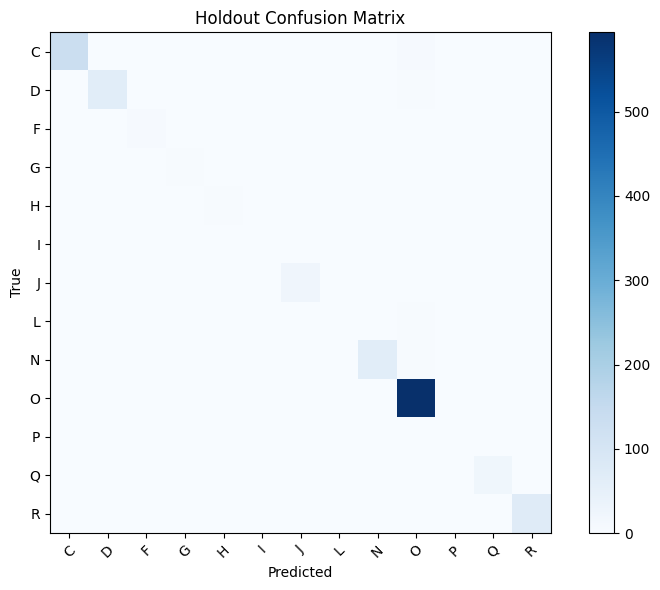


===== COMPUTING SHAP VALUES =====


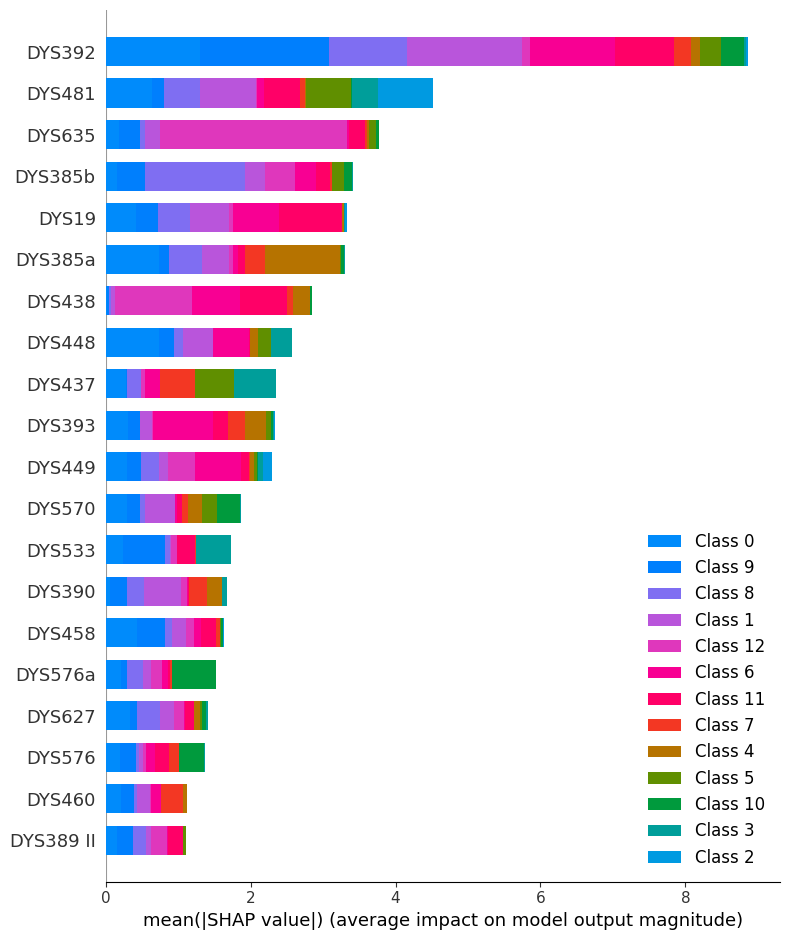

In [20]:
best_model_eval = evaluate_best_model(
    automl_df=automl_df,
    X_train_h=X_train_h,
    y_train_h=y_train_h,
    X_holdout=X_holdout,
    y_holdout=y_holdout,
    model_param_extractors=model_param_extractors
)

In [ ]:
import pickle

with open("final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)q

#### 4.3 Model Retraining and Cross-Validation

Using the optimized hyperparameters, the model was retrained and evaluated through cross-validation employing the Stratified K-Fold method. This is a variation of K-Fold wherein the folds are made by preserving the percentage of samples for each class in y in a binary or multiclass classification setting [9].

This ability to preserve the percentage of samples also helps address the issue regarding class imbalance.

## Results & Conclusion

After retraining the model and doing cross-validation, the model shows high and consistent training accuracy (0.98) and test accuracy (0.97) across folds, indicating strong generalization. Moreover, Macro-F1 scores (0.91–0.97) confirm balanced performance across haplogroups, not just dominant ones. The small Delta F1 macro (0.06) suggests minimal overfitting, as the gap between training and test performance is low. With these results, it can be assumed that the model performs robustly and reliably across all cross-validation folds.

### PCC Benchmark

In terms of benchmarking, the paper on YHP: Y-Chromosome Haplogroup Predictor, which predicts male lineages using Y-STR data, employed the prediction accuracies of several existing software tools as comparative baselines. However, these benchmarks are not directly applicable to the present study, as the referenced tools are designed primarily for haplotype prediction, whereas our work focuses on the prediction of major haplogroups.

Beyond the YHP framework, the closest available tool relevant to this research is the Y-STR Kinship-Index Calculation utility provided by the Y-Chromosome Haplotype Reference Database (YHRD). This tool computes the likelihood ratio of patrilineal relationship versus non-relationship for pairs of males based on their Y-STR profiles [10]. Nevertheless, it does not report standardized performance metrics; instead, it outputs probability-based evaluations that vary with each case-specific input, rendering it unsuitable as a consistent benchmark.

Given the absence of an established industry standard for evaluating haplogroup prediction models, this study adopts a **1.25 PCC at 47.60%** as the baseline against which model performance is compared.

It is worth noting however that the PCC is only restricted to the dataset and may not be representative of the entire population. As a recommendation, the performance of this ML model should be contextualized on the number of haplogroups in a population and its proportion to each other.

In [21]:
major_haplogroup_count = pd.DataFrame(df['major_haplogroup'].value_counts())
major_haplogroup_count['proportion'] = major_haplogroup_count['count'] / major_haplogroup_count['count'].sum()
major_haplogroup_count['proportion ^ 2'] = major_haplogroup_count['proportion']**2

pcc = major_haplogroup_count['proportion ^ 2'].sum()
pcc_125 = pcc*1.25
print(f'1.25 PCC = {pcc_125*100:.2f}%')

1.25 PCC = 47.60%


### Conclusion

Considering the results from the cross-validation, the Random Forest model surpasses the 1.25 PCC benchmark of 47.60% by a comfortable margin.

This study demonstrates a viable proof-of-concept for inferring paternal haplogroups from forensic Y-STR profiles using a Random Forest classifier. The model effectively predicts the likely lineage of an unknown male individual, providing an alternative source of investigative insight when direct database matches are unavailable.

Applied within the Philippine context, this approach has the potential to enhance forensic investigations by supplying additional, ancestry-based information from DNA evidence. While legal considerations regarding admissibility remain, the method offers a practical and ethically grounded tool for supporting law enforcement.

Overall, the findings illustrate the value of machine learning in advancing forensic analysis and contributing to the administration of justice.

## Recommendations

It was established that the results of this study indicate that the Random Forest algorithm, when optimized with the best-performing hyperparameters, provides a robust and reliable approach for predicting major haplogroups from Y-STR data.

Future research may benefit from implementing an AutoML framework at the subclade level to determine the most effective model for each subgroup. Given that the distributions and characteristics of the subclades differ within the dataset, a single global model may not adequately capture these variations.

Addressing class imbalance should also be a priority in subsequent work. Increasing the number of samples, particularly for underrepresented haplogroups, would help ensure more balanced model training. Alternatively, Synthetic Minority Over-sampling Technique (SMOTE) could be explored to generate additional synthetic samples for minority classes.

## References

[1] Song, M., Zhou, Y., Zhao, C., Song, F., & Hou, Y. (2024). YHP: Y-chromosome Haplogroup Predictor for predicting male lineages based on Y-STRs. Forensic Science International, 361, 112113. https://doi.org/10.1016/j.forsciint.2024.112113

[2] Roewer, S. W. a. L. (n.d.). Y-HRD China National Database. YHRD. https://yhrd.org/details/national_database/375-China

[3] Roy, B. (2020, April 6). All about Feature Scaling | Towards Data Science. Towards Data Science. https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35/

[4] GeeksforGeeks. (2018, July 2). Feature Engineering: Scaling, Normalization and Standardization. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/Feature-Engineering-Scaling-Normalization-and-Standardization/

[5] GeeksforGeeks. (2024, March 6). Gradient Boosting vs Random Forest. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/gradient-boosting-vs-random-forest/

[6] GeeksforGeeks. (2025, July 15). Advantages and Disadvantages of logistic regression. GeeksforGeeks. https://www.geeksforgeeks.org/data-science/advantages-and-disadvantages-of-logistic-regression/

[7] Haj. (2025, April). When (and When Not) to Use SVMs. Medium. https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba

[8] RandomForestClassifier. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[9] GeeksforGeeks. (2025b, July 15). Stratified K Fold Cross Validation. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

[10] Roewer, S. W. a. L. (n.d.). YHRD : Kinship Analysis. YHRD. https://yhrd.org/kinship